In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import einops
import pandas as pd
import os
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-14m"
hookpoints = ["gpt_neox.layers.3.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

In [4]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 20
}

sae = SAE_topk(meta_data=meta_data).to(device)

In [ ]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []
    

    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.hidden_activations
        active_neurons = len(torch.unique(hiddens.indices))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [14]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints    
]

for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

0.08917228877544403	261
0.08287383615970612	242
0.0813903734087944	193
0.07777177542448044	168
0.07328175008296967	162
0.07225434482097626	156
0.0664399266242981	161
0.059104908257722855	155
0.05790194123983383	158
0.05098694562911987	154
0.050489410758018494	152
0.0481560118496418	152
0.04443326219916344	155
0.042847275733947754	156
0.040280863642692566	154
0.03910765051841736	150
0.03811028227210045	152
0.036981645971536636	154
0.035544563084840775	154
0.03499946370720863	153
0.03307350352406502	154
0.03243608772754669	155
0.033337805420160294	158
0.031101807951927185	161
0.030633457005023956	157
0.029965639114379883	157
0.029513398185372353	157
0.028135674074292183	159
0.028997022658586502	158
0.02809918485581875	159
0.028136329725384712	158
0.02800682745873928	158
0.027767295017838478	158
0.027050701901316643	158
0.026419522240757942	159
0.024943741038441658	159
0.02555162087082863	160
0.025895703583955765	159
0.02552105486392975	160
0.025593897327780724	160
0.02433909848332405	160

KeyboardInterrupt: 

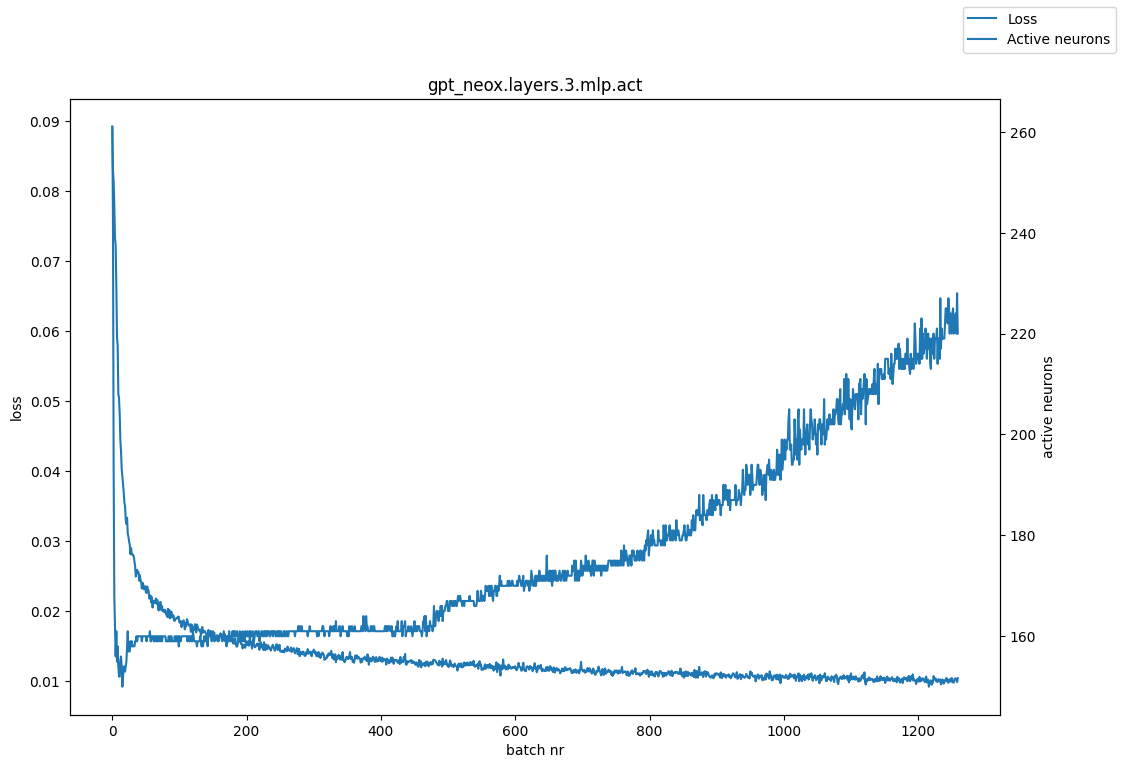

In [15]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint

    model_out_path = out_folder + f'/{hookpoint}.pt'
    meta_data_out_path = out_folder + f'/{hookpoint}.json'
    log_path = log_folder + f'/{hookpoint}.csv'
    log_fig_path = log_folder + f'/{hookpoint}.png'


    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)
    if not os.path.isdir(log_folder):
        os.mkdir(log_folder)

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses) 
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)